# Careers in gear
## Predict hire / nohire from lead_details.csv

### Logistic regression

## Limit train set to 500


In [2]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel('ERROR')

import shutil
import pathlib
import pickle
import itertools

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    average_precision_score
)

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, ElasticNetCV



from pp_pipeline_utils import (
    DataFrameSelector,
    CategoricalEncoder
)

from metric_utils import (
    plot_precision_recall,
    plot_roc,
    plot_precision_vs_score,
    precision_at_score_percentile,
    precision_by_score_buckets,
    plot_precision_by_score_buckets,
    plot_bucket_counts
)



In [3]:
np.random.seed(42)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette(sns.color_palette("Set2", 10))

In [5]:
features_file = 'data/cig_features.parq'

In [6]:
features = pd.read_parquet(features_file)

In [7]:
features.sample(5).T

,4522,2499,1413,4357,3830
lead_id,9055365,9337921,1660939,13010742,10484415
form_data_id,438970,454948,230119,1134721,672895
lead_match_client_id,5815,5709,10,11,5817
structured_campaign_name,Martin Resource Management : Regional (Martin ...,Trans System Inc : System Transport Pacific No...,US Xpress : Dedicated : p5 : a13 : M_1140093 (R),K and B Transportation Inc. : otr (OTR 4) : PM...,Ozark : Company Driver : PMC p5 : a1 : M_11350...
company_nicename,Martin Resource Management,System Transport,US Xpress,K&B Transportation,"Ozark Motor Lines, Inc"
full_name,Curtis Hale,Danny Malone,Louis Hubbard,ROBERT TOBAR,Joel Bishop
hired,0,0,1,1,1
city,Longview,Long Beach,Montgomery,Covington,Flat Rock
state,TX,CA,AL,TN,NC
zip,75604,90804,36106,38019,28731


In [8]:
features.hired.sum()

1558

In [9]:
p_hired = features.hired.sum() / len(features)
p_hired

0.30471347545472327

In [10]:
def ordinal_keys(s):
    sset = set(s)
    sset.add('')
    return sorted(sset)

In [11]:
category_keys = [
    'driver_type',
    'climate_region'
]

for ck in category_keys:
    features[ck] = features[ck].fillna('')

category_values = {x: ordinal_keys(features[x].unique()) for x in category_keys}
category_lookup = {x:x for x in category_keys}

def get_cat_vals(cat):
    return category_values[category_lookup[cat]]

def make_cat_encoder(atts, encoding='onehot', handle_unknown='ignore'):
    return CategoricalEncoder(encoding=encoding,
                              categories=[get_cat_vals(x) for x in atts],
                              handle_unknown=handle_unknown)

In [12]:
numeric_atts = [
    'exp_yr_num',
    'tickets',
    # rest are boolean
    
    'lease_purchase',
    'drivers_license_class_a',
    'hazmat',
    'tanker',
    'doublestriples',
    'job_alerts',
    'sms_alerts_opt_in',
    'came_from_suggested_job',
    'run_single',
    'run_team',
    'flatbed',
    'van',
    'reefer',
    'multi',
    'oversized',
    'stepdeck',
    'heavy_haul',
    'haul_tanker',
]

category_atts = [
    'driver_type',
    'climate_region'
]

In [13]:
train_set, test_set = train_test_split(features.copy(), test_size=0.2)
len(train_set), len(test_set)

(4090, 1023)

In [14]:
train_set = train_set.sample(500)

In [15]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(numeric_atts)),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(category_atts)),
    ('cat_encoder', make_cat_encoder(category_atts, encoding='onehot', handle_unknown='error'))
])

pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [16]:
%%time
pipeline.fit(train_set)

CPU times: user 3.26 ms, sys: 1.07 ms, total: 4.33 ms
Wall time: 3.51 ms


FeatureUnion(n_jobs=None,
             transformer_list=[('num_pipeline',
                                Pipeline(memory=None,
                                         steps=[('selector',
                                                 DataFrameSelector(attribute_names=['exp_yr_num',
                                                                                    'tickets',
                                                                                    'lease_purchase',
                                                                                    'drivers_license_class_a',
                                                                                    'hazmat',
                                                                                    'tanker',
                                                                                    'doublestriples',
                                                                                    'job_alerts',
                 

In [17]:
X_train = pipeline.transform(train_set).toarray()
y_train = train_set.hired

In [18]:
X_test = pipeline.transform(test_set).toarray()
y_test = test_set.hired

In [19]:
X_train.shape, X_test.shape

((500, 37), (1023, 37))

In [20]:
n_train_records, n_features = X_train.shape
n_train_records, n_features

(500, 37)

In [21]:
col_nonzero_fractions = np.asarray((np.sum((X_train > 0), axis=0) / n_train_records)).ravel()
col_nonzero_fractions.shape

(37,)

In [22]:
def get_colnames(pipeline):
    num_pipeline = pipeline.get_params()['transformer_list'][0][1]
    numparams = num_pipeline.get_params()['selector__attribute_names']

    cat_pipeline = pipeline.get_params()['transformer_list'][1][1]
    catfields = cat_pipeline.get_params()['selector__attribute_names']
    catvals = cat_pipeline.get_params()['cat_encoder__categories']
    catparams = [x + '=' + y for (x, ys) in zip(catfields, catvals) for y in ys]

    return numparams + catparams

In [23]:
colnames = get_colnames(pipeline)
colnames

['exp_yr_num',
 'tickets',
 'lease_purchase',
 'drivers_license_class_a',
 'hazmat',
 'tanker',
 'doublestriples',
 'job_alerts',
 'sms_alerts_opt_in',
 'came_from_suggested_job',
 'run_single',
 'run_team',
 'flatbed',
 'van',
 'reefer',
 'multi',
 'oversized',
 'stepdeck',
 'heavy_haul',
 'haul_tanker',
 'driver_type=',
 'driver_type=company_driver',
 'driver_type=lease_purchase',
 'driver_type=owner_operator',
 'driver_type=student',
 'climate_region=',
 'climate_region=AK',
 'climate_region=C',
 'climate_region=ENC',
 'climate_region=HI',
 'climate_region=NE',
 'climate_region=NW',
 'climate_region=S',
 'climate_region=SE',
 'climate_region=SW',
 'climate_region=W',
 'climate_region=WNC']

In [24]:
def feature_coefficients_df(model):
    coefs = model.coef_.ravel()
    df = (pd.DataFrame({'field': colnames,
                      'coef': coefs,
                      'abs_coef': np.abs(coefs),
                      'nonzero_rows': col_nonzero_fractions}))
    df['importance'] = df['abs_coef'] * df['nonzero_rows']
    df.index.name = 'col_num'
    return df.sort_values(['importance'], ascending=False)
    return df

In [25]:
balanced_class_weight = compute_class_weight('balanced', [0,1], y_train)
balanced_class_weight

array([0.71022727, 1.68918919])

## L2 penalty

In [26]:
model_l2 = LogisticRegressionCV(scoring='roc_auc', class_weight='balanced', cv=5, max_iter=1000)

In [27]:
%time model_l2.fit(X_train, y_train)

CPU times: user 2.85 s, sys: 2.8 s, total: 5.65 s
Wall time: 730 ms


LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True,
                     scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=0)

In [28]:
model_l2.C_

array([0.04641589])

In [29]:
y_score_l2 = model_l2.predict_proba(X_test)[:, 1]

In [30]:
roc_auc_score(y_test, y_score_l2)

0.7869063074759277

In [31]:
average_precision_score(y_test, y_score_l2)

0.6216225834076667

In [32]:
precision_at_score_percentile(y_test, y_score_l2, 80)

0.7219512195121951

In [33]:
precision_at_score_percentile(y_test, y_score_l2, 90)

0.7766990291262136

In [34]:
precision_at_score_percentile(y_test, y_score_l2, 99)

0.6363636363636364

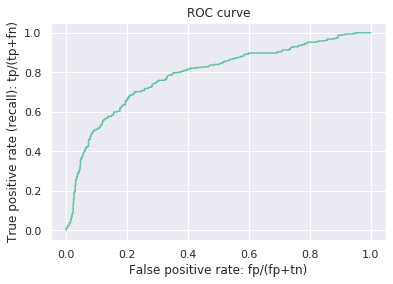

In [35]:
plot_roc(y_test, y_score_l2)

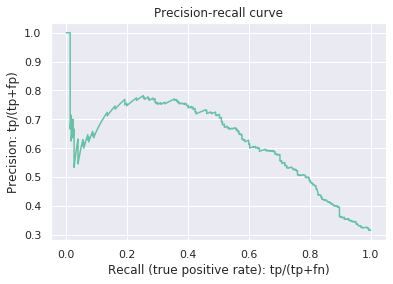

In [36]:
plot_precision_recall(y_test, y_score_l2)

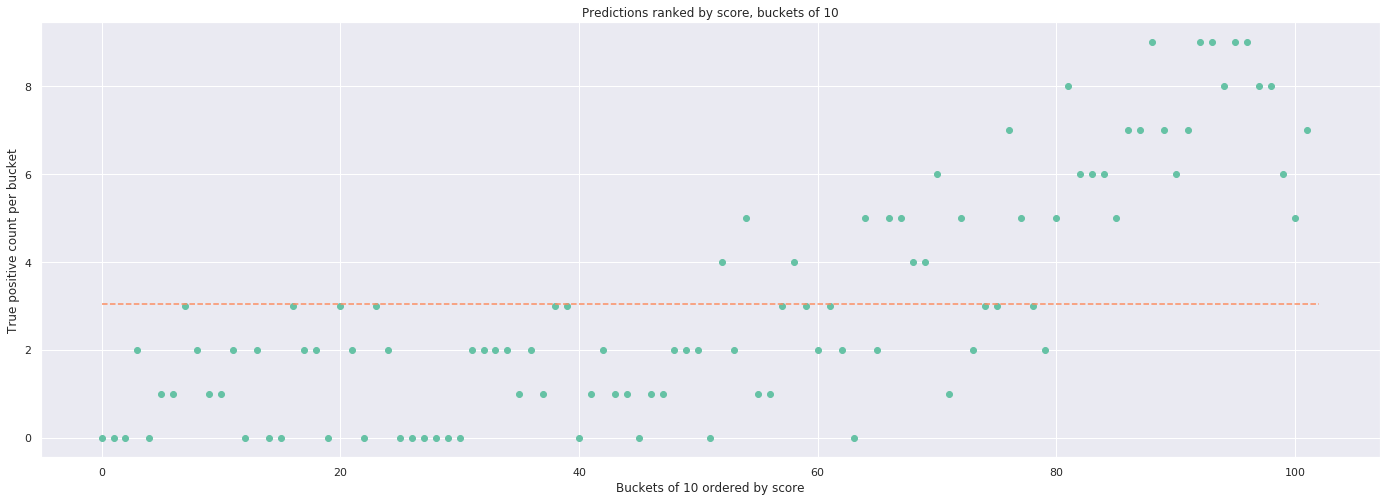

In [37]:
plt.figure(figsize=(24,8))
plot_bucket_counts(y_test, y_score_l2, 10)

In [38]:
feature_coefficients_df(model_l2)

,field,coef,abs_coef,nonzero_rows,importance
col_num,,,,,
10,run_single,-0.643985,0.643985,0.712,0.458518
9,came_from_suggested_job,-0.316859,0.316859,0.706,0.223702
3,drivers_license_class_a,0.198539,0.198539,0.968,0.192186
8,sms_alerts_opt_in,-0.270026,0.270026,0.692,0.186858
12,flatbed,-0.328851,0.328851,0.252,0.082870
11,run_team,-0.616133,0.616133,0.134,0.082562
7,job_alerts,0.109834,0.109834,0.730,0.080179
32,climate_region=S,-0.249383,0.249383,0.300,0.074815
13,van,0.153320,0.153320,0.442,0.067767


## L1 penalty
Use L1 penalty to flag most important features for model.

In [39]:
model_l1 = LogisticRegression(class_weight='balanced', penalty='l1', C=0.05)

In [40]:
%time model_l1.fit(X_train, y_train)

CPU times: user 670 µs, sys: 1.78 ms, total: 2.45 ms
Wall time: 2.06 ms


/home/wleftwich/anaconda3/envs/tfgpu/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.05, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
y_score_l1 = model_l1.predict_proba(X_test)[:, 1]

In [42]:
roc_auc_score(y_test, y_score_l1)

0.7744757293807927

In [43]:
average_precision_score(y_test, y_score_l1)

0.6080773685405509

In [44]:
precision_at_score_percentile(y_test, y_score_l1, 80)

0.6987951807228916

In [45]:
precision_at_score_percentile(y_test, y_score_l1, 90)

0.7777777777777778

In [46]:
precision_at_score_percentile(y_test, y_score_l1, 99)

0.6382978723404256

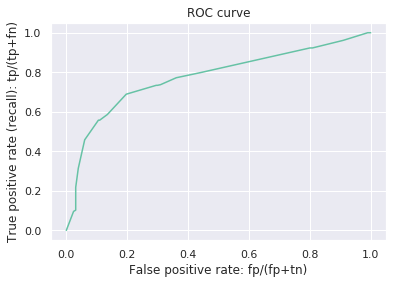

In [47]:
plot_roc(y_test, y_score_l1)

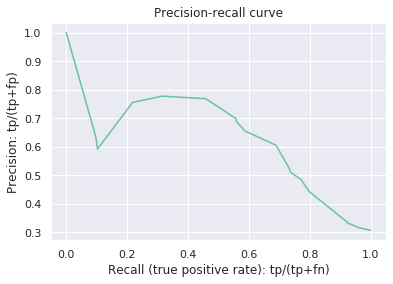

In [48]:
plot_precision_recall(y_test, y_score_l1)

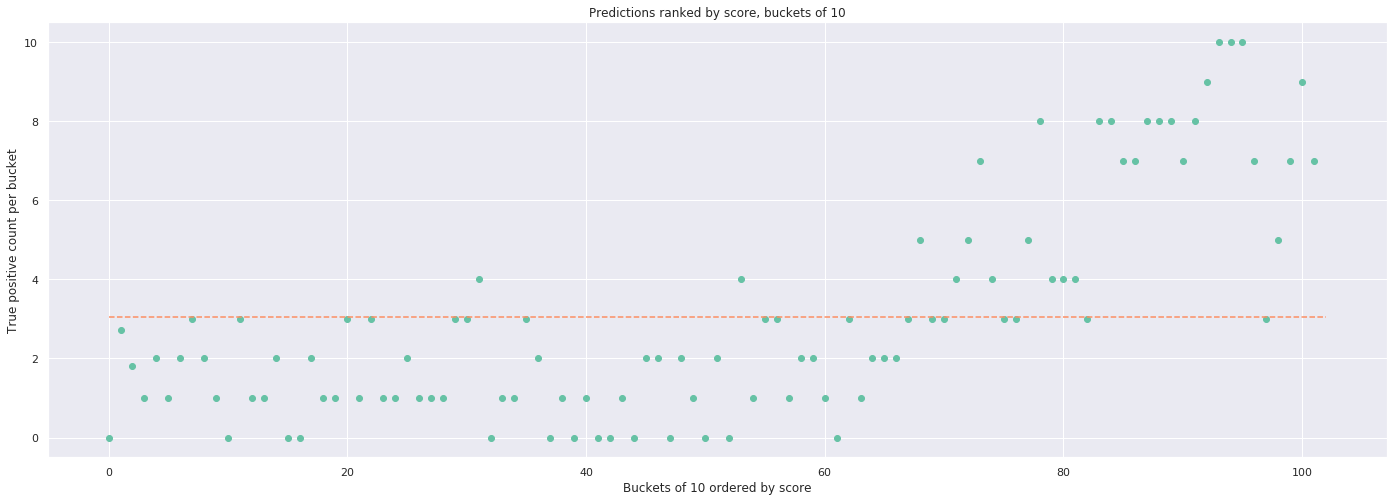

In [49]:
plt.figure(figsize=(24,8))
plot_bucket_counts(y_test, y_score_l1, 10)

In [50]:
coefs = feature_coefficients_df(model_l1)
coefs

,field,coef,abs_coef,nonzero_rows,importance
col_num,,,,,
10,run_single,-0.491953,0.491953,0.712,0.350271
9,came_from_suggested_job,-0.174292,0.174292,0.706,0.123050
8,sms_alerts_opt_in,-0.157677,0.157677,0.692,0.109113
11,run_team,-0.473409,0.473409,0.134,0.063437
12,flatbed,-0.142714,0.142714,0.252,0.035964
23,driver_type=owner_operator,0.000000,0.000000,0.070,0.000000
24,driver_type=student,0.000000,0.000000,0.084,0.000000
25,climate_region=,0.000000,0.000000,0.002,0.000000
26,climate_region=AK,0.000000,0.000000,0.002,0.000000


In [51]:
coefs.to_excel('data/cig-lr-l1-coefs-c_pt_05.xlsx')